# Projeto 1 - Ciência dos Dados

Nome: Pedro Henrique

Nome: Vitor Katakura

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [141]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [142]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
/home/vitorhideki/www/python/cdados-p1


Carregando a base de dados com os tweets classificados manualmente e as stop words:

In [143]:
stop_words = pd.read_csv('stopwords.csv', header=None)[0].to_list()

In [144]:
train = pd.read_excel('dados_treino.xlsx')

In [145]:
test = pd.read_excel('dados_teste.xlsx')

In [146]:
stop_words = pd.read_csv('stopwords.csv', header=None)[0].to_list()

___
## Classificador automático


Na classificação dos comentários, nós consideramos que somos funcionários da Amazon e gostaríamos de filtrar quais comentários feitos por clientes são relacionados à problemas com a empresa e quais são relacionados à comentários sobre o livro. Para isso, utilizamos 3 variáveis relevantes na classificação: Problemas com a Amazon, comentários sobre o livro e outros.

* $A$: Problemas com a Amazon
* $L$: Comentários sobre o livro
* $O$: Outros


___
### Montando um Classificador Naive-Bayes

In [147]:
legenda = {'Problemas com a Amazon': 1, 'Comentários sobre o livro': 2, 'outros': 3}

In [148]:
# Removendo as colunas que não serão utilizadas
train = train.loc[:,['Mensagem', 'Target']]
test = test.loc[:,['Mensagem', 'Target']]

<b>Limpeza dos tweets</b>

Aqui implementamos uma função que recebe um texto e remove dele todas as pontuações, emoticons e stop words.

In [149]:
import re 

def cleanup(text):
    pattern = re.compile(r'[\`\"\!\-\.\:\?\;\$\'\,]')
    emoji_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        "]+", flags=re.UNICODE)
    
    texto_sem_pontos = re.sub(pattern, '', text)
    texto_sem_emoticons = re.sub(emoji_pattern, '', texto_sem_pontos)

    texto_limpo = ''
    for palavra in texto_sem_emoticons.split():
        if palavra not in stop_words:
            texto_limpo += palavra + ' '

    return texto_limpo.lower()

In [150]:
train['Mensagem'] = train['Mensagem'].apply(cleanup)
test['Mensagem'] = test['Mensagem'].apply(cleanup)
train_100 = train.copy()
test_100 = test.copy()

In [151]:
# Transformando os valores numéricos da variável target na base de dados treino em categóricos
train['Mensagem'] = train['Mensagem'].astype('category')
train['Target'] = train['Target'].astype('category')

train['Target'] = train['Target'].cat.rename_categories(['Problemas com a Amazon', 'Comentários sobre o livro', 'Outros'])

In [152]:
# Transformando os valores numéricos da variável target na base de dados teste em categóricos
test['Mensagem'] = test['Mensagem'].astype('category')
test['Target'] = test['Target'].astype('category')

test['Target'] = test['Target'].cat.rename_categories(['Problemas com a Amazon', 'Comentários sobre o livro', 'Outros'])

<b>Tabela de frequências das palavras</b>

Aqui, conseguimos obter as probabilidades de cada categoria:

* $P(A)$ = 0.686667
* $P(L)$ = 0.213333
* $P(O)$ = 0.1

In [153]:
tabela_relativa = train['Target'].value_counts(True)

P_amazon = tabela_relativa['Problemas com a Amazon']
P_livro = tabela_relativa['Comentários sobre o livro']
P_outros = tabela_relativa['Outros']
tabela_relativa.to_frame()

,proportion
Target,
Comentários sobre o livro,0.686667
Problemas com a Amazon,0.213333
Outros,0.100000


In [154]:
palavras = ''

for i in range(len(train['Mensagem'])):
    palavras += train['Mensagem'][i] + ' '

palavras = palavras.split()
palavras = pd.Series(list(set(palavras))) # Variável que armazena todas as palavras diferentes da base de treino
n_palavras_diff = len(palavras) # Variável que armazena a quantidade de palavras diferentes da base de treino

In [155]:
palavras_amazon = ''

amazon = train.loc[train['Target'] == 'Problemas com a Amazon', ['Mensagem']]
amazon = amazon.reset_index(drop=True)

for i in range(len(amazon['Mensagem'])):
    palavras_amazon += amazon['Mensagem'][i] + ' '

palavras_amazon_lista = palavras_amazon.split()
palavras_amazon = pd.Series(palavras_amazon_lista)
P_palavra_dado_amazon = palavras_amazon.value_counts() # Variável que armazena as palavras e suas respectivas quantidades de vezes que apareceram na categoria Amazon
n_palavras_amazon = len(palavras_amazon) # Variável que armazena a quantidade de palavras na categoria Amazon

In [156]:
palavras_livro = ''

livro = train.loc[train['Target'] == 'Comentários sobre o livro', ['Mensagem']]
livro = livro.reset_index(drop=True)

for i in range(len(livro['Mensagem'])):
    palavras_livro += livro['Mensagem'][i] + ' '

palavras_livro_lista = palavras_livro.split()
palavras_livro = pd.Series(palavras_livro_lista)
P_palavra_dado_livro = palavras_livro.value_counts() # Variável que armazena as palavras e suas respectivas quantidades de vezes que apareceram na categoria Livros
n_palavras_livro = len(palavras_livro) # Variável que armazena a quantidade de palavras na categoria Livros

In [157]:
palavras_outros = ''

outros = train.loc[train['Target'] == 'Outros', ['Mensagem']]
outros = outros.reset_index(drop=True)

for i in range(len(outros['Mensagem'])):
    palavras_outros += outros['Mensagem'][i] + ' '

palavras_outros_lista = palavras_outros.split()
palavras_outros = pd.Series(palavras_outros_lista)
P_palavra_dado_outros = palavras_outros.value_counts() # Variável que armazena as palavras e suas respectivas quantidades de vezes que apareceram na categoria Outros
n_palavras_outros = len(palavras_outros) # Variável que armazena a quantidade de palavras na categoria Outros

___
### Verificando a performance do Classificador

Aqui testaremos o nosso classificador utilizando os métodos de Naive Bayes e Suavização de Laplace

In [158]:
for i, frase in test['Mensagem'].items():
    frase = frase.split()
    prob_amazon = 1
    prob_livro = 1
    prob_outros = 1
    for palavra in frase:
        if palavra not in palavras_amazon_lista:
            prob_amazon *= (0 + 1)/(n_palavras_amazon + n_palavras_diff) * 10e2
        else:
            prob_amazon *= (P_palavra_dado_amazon[palavra] + 1)/(n_palavras_amazon + n_palavras_diff) * 10e2
        
        if palavra not in palavras_livro_lista:
            prob_livro *= (0 + 1)/(n_palavras_livro + n_palavras_diff) * 10e2
        else:
            prob_livro *= (P_palavra_dado_livro[palavra] + 1)/(n_palavras_livro + n_palavras_diff) * 10e2
        
        if palavra not in palavras_outros_lista:
            prob_outros *= (0 + 1)/(n_palavras_outros + n_palavras_diff) * 10e2
        else:
            prob_outros *= (P_palavra_dado_outros[palavra] + 1)/(n_palavras_outros + n_palavras_diff) * 10e2
    
    if prob_amazon > prob_livro and prob_amazon > prob_outros:
        test.loc[i, 'Predição'] = 'Problemas com a Amazon'
    elif prob_livro > prob_amazon and prob_livro > prob_outros:
        test.loc[i, 'Predição'] = 'Comentários sobre o livro'
    elif prob_outros > prob_amazon and prob_outros > prob_livro:
        test.loc[i, 'Predição'] = 'Outros'

In [159]:
test['Predição'] = test['Predição'].astype('category')

test['Predição'] = test['Predição'].cat.reorder_categories(['Problemas com a Amazon', 'Comentários sobre o livro', 'Outros'])

In [160]:
tabela = pd.crosstab(test['Predição'], test['Target'], normalize='all')
tabela

Target,Problemas com a Amazon,Comentários sobre o livro,Outros
Predição,,,
Problemas com a Amazon,0.190,0.030,0.055
Comentários sobre o livro,0.000,0.540,0.040
Outros,0.005,0.095,0.045


In [161]:
V_amazon = tabela['Problemas com a Amazon']['Problemas com a Amazon']
F_amazon = tabela['Comentários sobre o livro']['Problemas com a Amazon'] + tabela['Outros']['Problemas com a Amazon']
V_livro = tabela['Comentários sobre o livro']['Comentários sobre o livro']
F_livro = tabela['Problemas com a Amazon']['Comentários sobre o livro'] + tabela['Outros']['Comentários sobre o livro']
V_outros = tabela['Outros']['Outros']
F_outros = tabela['Comentários sobre o livro']['Outros'] + tabela['Problemas com a Amazon']['Outros']
Acur = V_amazon + V_livro + V_outros
print(f'Acurácia: {Acur*100}%, \nVerdadeiros Amazon: {V_amazon*100}%, \nFalsos Amazon: {F_amazon*100}%, \nVerdadeiro Livro: {V_livro*100}%, \nFalso Livro: {F_livro*100}%, \nVerdadeiro Outros: {V_outros*100}%, \nFalso Outros: {F_outros*100}%')

Acurácia: 77.5%, 
Verdadeiros Amazon: 19.0%, 
Falsos Amazon: 8.5%, 
Verdadeiro Livro: 54.0%, 
Falso Livro: 4.0%, 
Verdadeiro Outros: 4.5%, 
Falso Outros: 10.0%


___
## Concluindo

### Interpretando os resultados do classificador
Como mencionado anteriormente, nós somos funcionários da Amazon e gostaríamos de filtrar quais comentários são sobre problemas com a empresa e quais são relacionados com o livro. Para isso, utilizamos 3 targets na classificação das mensagens: Problemas com a Amazon, comentários sobre o livro e outros.


<b>Acurácia</b>
* A acurácia do classificador foi de 77,5%. Ou seja, um resultado bom, porém vale ressaltar que a base de dados de treinamento não apresentava equilíbrio entre as categorias o que pode tornar o algoritmo enviesado, por possuir mais dados para treinamento da categoria comentários sobre o livro.

<b>Predições sobre a Amazon</b>
* Dos comentários que eram sobre a Amazon, o classificador conseguiu acertar 69%, portanto é possível dizer, que é um resultado bom considerando a divisão desproporcional das categorias, que acabou influenciando negativamente nas predições.

<b>Predições sobre os Livros</b>
* Dos comentários que eram sobre Livros, o classificador conseguiu acertar 93.1%. Isso pode ser explicado pelo desequilíbrio da base de dados treino, fazendo oo algoritmo ficar melhor em prever comentários sobre o livro.

<b>Predições sobre Outros</b>
* Dos comentários que eram sobre Outros, o classificador conseguiu acertar 31%, a predição dessa categoria foi a que teve oo pior resultado, o que pode ser explicado por ser também a categoria que possui menos dados na base de dados de treino do algoritmo.

<b>Mensagens de dupla negação e sarcásticas</b>
* O classificador não consegue identificar mensagens de dupla negação e sarcásticas, pois ele não consegue identificar o contexto da mensagem, apenas as palavras que estão sendo utilizadas.

<b>Plano de expansão</b>
* Para melhorar a acurácia do classificador, uma próxima etapa seria homogenizar a quantidade de comentários de cada categoria, para que o classificador não tenha uma tendência a classificar os comentários como "Livro", pois é a categoria com mais comentários.

* Para melhorar o tratamento das mensagens da base de dados e consequentemente a performance, é interessante utilizar outras técnicas de limpeza, como por exemplo, o Lemmatization, que é uma técnica que reduz as palavras para o seu radical para poder analisar pelo puro significado delas, por exemplo, "correr", "correndo", "correu" e "corrida" são reduzidas para "corre".

___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste


In [162]:
import sklearn.model_selection as skl

In [163]:
dados_100 = pd.concat([train_100, test_100])
dados_100 = dados_100.reset_index(drop=True)

In [164]:
Acur_lista = []
verdadeiros_positivos = []
verdadeiros_negativos = []

In [165]:
def calcular_estatisticas_categoria(categoria):
    mensagens_categoria = train[train['Target'] == categoria]['Mensagem']
    palavras_categoria = ' '.join(mensagens_categoria)
    palavras_categoria = pd.Series(palavras_categoria.split())
    P_palavra_dado_categoria = palavras_categoria.value_counts()
    n_palavras_categoria = len(palavras_categoria)
    return P_palavra_dado_categoria, n_palavras_categoria

Acur_lista = []

for rs in range(100):
    train, test = skl.train_test_split(dados_100, test_size=0.4, random_state=rs)
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)

    train['Mensagem'] = train['Mensagem'].astype('category')
    train['Target'] = train['Target'].astype('category')

    test['Mensagem'] = test['Mensagem'].astype('category')
    test['Target'] = test['Target'].astype('category')

    tabela_relativa = train.Target.value_counts(normalize=True)

    P_amazon = tabela_relativa[1]
    P_livro = tabela_relativa[2]
    P_outros = tabela_relativa[3]

    # Total de palavras diferentes na base
    palavras = ' '.join(train['Mensagem']).split()
    palavras = pd.Series(list(set(palavras)))
    n_palavras_diff = len(palavras)

    # Calcular estatísticas para cada categoria
    P_palavra_dado_amazon, n_palavras_amazon = calcular_estatisticas_categoria(1)
    P_palavra_dado_livro, n_palavras_livro = calcular_estatisticas_categoria(2)
    P_palavra_dado_outros, n_palavras_outros = calcular_estatisticas_categoria(3)

    # Verificando a probabilidade de cada frase pertencer a cada categoria
    test['Predição'] = 0  # Inicializa com 0

    for i, frase in enumerate(test['Mensagem']):
        palavras_frase = frase.split()
        prob_amazon = np.prod([(P_palavra_dado_amazon.get(palavra, 0) + 1) / (n_palavras_amazon + n_palavras_diff) * 10e2 for palavra in palavras_frase])
        prob_livro = np.prod([(P_palavra_dado_livro.get(palavra, 0) + 1) / (n_palavras_livro + n_palavras_diff) * 10e2 for palavra in palavras_frase])
        prob_outros = np.prod([(P_palavra_dado_outros.get(palavra, 0) + 1) / (n_palavras_outros + n_palavras_diff) * 10e2 for palavra in palavras_frase])
        
        if prob_amazon > prob_livro and prob_amazon > prob_outros:
            test.loc[i, 'Predição'] = 1
        elif prob_livro > prob_amazon and prob_livro > prob_outros:
            test.loc[i, 'Predição'] = 2
        elif prob_outros > prob_amazon and prob_outros > prob_livro:
            test.loc[i, 'Predição'] = 3

    test['Predição'] = test['Predição'].astype('category')
    test['Predição'] = test['Predição'].cat.reorder_categories([1, 2, 3])

    tabela = pd.crosstab(test['Predição'], test['Target'], normalize='all')
    V_amazon = tabela[1][1]
    V_livro = tabela[2][2]
    V_outros = tabela[3][3]
    Acur = V_amazon + V_livro + V_outros
    Acur_lista.append(Acur*100)

In [166]:
pd.DataFrame(Acur_lista).describe()

,0
count,100.000000
mean,76.705000
std,2.697825
min,69.000000
25%,75.000000
50%,76.500000
75%,78.500000
max,82.500000


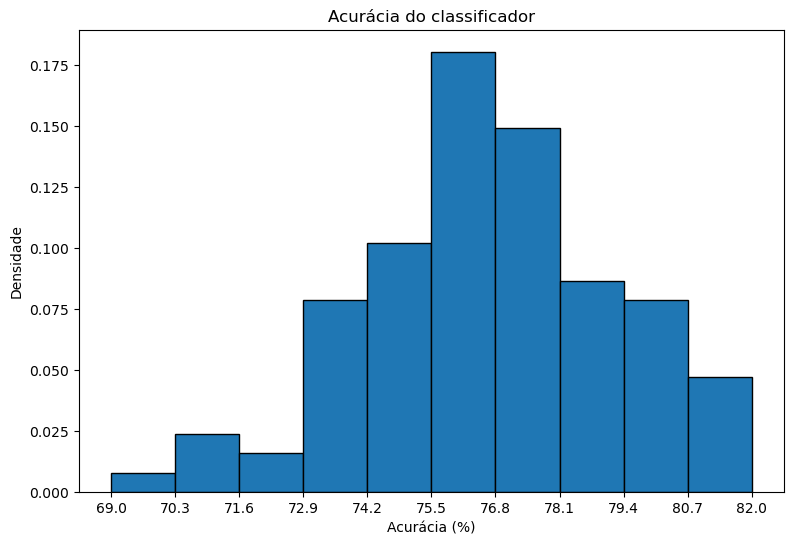

In [167]:
amp = np.arange(69, 82.5, 1.3)

plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.hist(Acur_lista, bins=amp, density=True, edgecolor="black")
plt.title("Acurácia do classificador")
plt.xlabel("Acurácia (%)")
plt.ylabel("Densidade")
plt.xticks(amp)
plt.show()

### Análise do histograma
* Com base no histograma, a faixa de acurácia com mais ocorrência, ou seja, maior densidade, foi a de 75.5% até 76.8%, e as demais probabilidades de distribuem em torno disso, sendo as faixas mais a esquerda com densidade menor. Ou seja, é um histograma com assimetria à esquerda, o que indica ser um resultado bom, porém vale ressaltar que a base de dados de treinamento não apresentava equilíbrio entre as categorias o que pode tornar o algoritmo enviesado, por possuir mais dados para treinamento da categoria comentários sobre o livro.

___
## Aperfeiçoamento:

### Diferentes cenários para o classificador Naive-Bayes
* <b>Detector de plágio em texto de alunos</b> : A partir de uma base de dados com textos gerados por inteligências artificiais, é possível comparar as identidades textuais dos alunos com a da máquina a fim de identificar algum plágio.

* <b>Detecção de Tópicos de Interesse</b> : Em aplicações de recomendação, o Naive-Bayes pode ajudar a identificar tópicos de interesse do usuário, analisando os textos que o usuário lê ou interage com regularidade.

### Porquê não podemos utilizar o próprio classificador para gerar mais amostras?
* Não é recomendado utilizar o próprio classificador para gerar mais amostras pois como é um classificador Naive-Bayes, ele assume que as palavras são independentes entre si, o que não é verdade. Além disso, o classificador pode acabar se tornando enviesado, pois ele vai acabar classificando os comentários de acordo com a base de dados que ele já tem, o que pode acabar gerando um classificador que não é tão eficiente.

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**